In [1]:
# Libraries
import numpy as np
import astropy.units as u
from astropy.constants import G

# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
from tqdm import tqdm

# my modules
from ReadFile import Read
from MassProfile import MassProfile
from CenterOfMass import CenterOfMass

# ASTR 400B: Research Assignment
By: Colton Quirk

1. Topic of Research Assignment

   How the tidal forces affect the rotation curve of M31 and the MW.
   
2. One Question


   Evolution of M31 Rotation Curve over time

3. One Plot to Create

   Animation of M31 rotation curve over time

## Outline of the Code

1. Read in data
2. Compute MassDerived Rotation curve and Line of Sight rotation curve
3. Make an animation showing how this changes over time

## To Do:

1. Add functionality to analyze Disk and Bulge Particles

In [2]:
def RotateFrame(posI,velI):
    """a function that will rotate the position and velocity vectors
    so that the disk angular momentum is aligned with z axis. 
    
    PARAMETERS
    ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
    RETURNS
    -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) 
            such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) 
            such that disk angular momentum vector
            is in the +z direction 
    """
    
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    
    # normalize the angular momentum vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to
    # z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel

In [3]:
def Relative_Pos_Vel(COMD):
    # Compute COM of the Galaxy using disk particles
    COMP = COMD.COM_P(0.1)
    COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])

    # Determine positions of disk particles relative to COM 
    xD = COMD.x - COMP[0].value 
    yD = COMD.y - COMP[1].value 
    zD = COMD.z - COMP[2].value 
    
    # total magnitude
    rtot = np.sqrt(xD**2 + yD**2 + zD**2)
    
    # Determine velocities of disk particles relative to COM motion
    vxD = COMD.vx - COMV[0].value 
    vyD = COMD.vy - COMV[1].value 
    vzD = COMD.vz - COMV[2].value 
    
    # total velocity 
    vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)
    
    # Arrays for r and v 
    r = np.array([xD,yD,zD]).T # transposed 
    v = np.array([vxD,vyD,vzD]).T

    return r, v

In [4]:
def Cylindrical_Coords(rn, vn):
    # radius 
    rho = np.sqrt(rn[:,0]**2 + rn[:,1]**2)
    
    # velocity in cylindrical coordinates. 
    # radius 
    rho = np.sqrt(rn[:,0]**2 + rn[:,1]**2) 
    
    # radial velocity 
    vr = (rn[:,0] * vn[:,0] + rn[:,1] * vn[:,1]) / rho
    
    # azimuthal velocity
    vphi = (rn[:,0] *  vn[:,1] - rn[:,1] * vn[:,0]) / rho

    return rho, vr, vphi

In [23]:
class Rotation_Curves:
    def __init__(self, Galaxy_Name, snap_ids, r_start=0.01, r_end=45, dr = 0.1, High_Res=False):
        self.gname = Galaxy_Name
        self.snap_ids = snap_ids

        if High_Res:
            path = f"VHighRes\\{Galaxy_Name}\\"
            fnames = [f"{Galaxy_Name}_{snap_id:0>3}_HighRes.txt" for snap_id in self.snap_ids]
        else:
            path = f"VLowRes\\{Galaxy_Name}\\"
            fnames = [f"{Galaxy_Name}_{snap_id:0>3}.txt" for snap_id in self.snap_ids]

        self.path = path
        self.fnames = fnames

        # General radii for plotting/fitting
        # Positions for MassProfile
        # And Positions for "Observed" Rotation Curve
        self.dr = dr
        self.radii = np.arange(r_start, r_end, dr)

        # Derived from MassProfile
        self.Vcircs = np.zeros((self.snap_ids.shape[0], self.radii.shape[0]))

        # Observed Values
        self.v2s = np.zeros((self.snap_ids.shape[0], self.radii.shape[0]))

        # rhos and vphis for observed rotation curve
        # WHERE DOES 60000 come from!?! Needs to be programatic
        if self.gname == "M31":
            self.rhos = np.zeros((self.snap_ids.shape[0], 60000))
            self.vphis = np.zeros((self.snap_ids.shape[0], 60000))
        elif self.gname == "MW":
            self.rhos = np.zeros((self.snap_ids.shape[0], 37500))
            self.vphis = np.zeros((self.snap_ids.shape[0], 37500))
            
        self.residuals = np.zeros_like(self.Vcircs)

    def Calculate_Rotation_Curves(self):
        for i, snap_id in enumerate(tqdm(self.snap_ids)):
            fname = self.fnames[i]
    
            # create a mass profile object for the Galaxy
            Profile = MassProfile(self.path+self.gname, snap_id)
            # Circular velocity profile
            Vcirc = Profile.CircularVelocityTotal(self.radii)
            # Store the Calculated Circular Velocity Profile
            self.Vcircs[i] = Vcirc
    
            # Create a Center Of Mass Object for the file
            # use Disk Particles (ptype=2)
            COMD = CenterOfMass(self.path+fname,2)
            # Get the positions and velocities relative to the center of mass
            r, v = Relative_Pos_Vel(COMD)
            # compute the rotated position and velocity vectors
            rn, vn = RotateFrame(r, v)
            # Convert to cylindrical coordinates
            rho, vr, vphi = Cylindrical_Coords(rn, vn)

            # Determine the mean vphi per radius
            # Initialize Empty Array for Velocity 
            # (same size as radial array)
            v2 = np.zeros_like(self.radii) 
            # compute the mean vphi in radial bins
            for j, radius in enumerate(self.radii):
                index = np.where((rho > radius) & (rho < radius+self.dr)) # walking out in radial bins
                v2[j] = np.mean(np.abs(vphi[index])) # mean velocity

            self.v2s[i] = v2

            self.rhos[i] = rho
            self.vphis[i] = np.abs(vphi)

    def calc_residuals(self):
        self.residuals = self.Vcircs - self.v2s # Residuals are predicted - observed

    def plot_residuals(self, snap_id, save=False):
        index = np.where(self.snap_ids == snap_id)[0][0]
        residual = self.residuals[index]

        fontsize = 18
        label_size = fontsize
        
        matplotlib.rcParams['xtick.labelsize'] = label_size 
        matplotlib.rcParams['ytick.labelsize'] = label_size

        fig, ax = plt.subplots(figsize=(1.2*6, 6), layout="constrained")
        ax.plot(self.radii, residual, color="Red", lw=2, linestyle="--", label="Residuals")

        ax.set_xlabel('R (kpc)', fontsize=fontsize)
        ax.set_ylabel(r'Residuals (km/s)', fontsize=fontsize)
        ax.set_title(f"Residual Plots of {self.gname} at snap number {snap_id:0>3}", fontsize=fontsize)
        ax.legend()
        
        if save:
            fig.savefig(f"{self.gname}_Plots\\Residuals\\{self.gname}_{snap_id:0>3}_rotation_curve.png")
            
        plt.show()

    def plot_all_curves(self):
        fontsize = 18
        label_size = fontsize
        
        matplotlib.rcParams['xtick.labelsize'] = label_size 
        matplotlib.rcParams['ytick.labelsize'] = label_size

        

        fig, ax = plt.subplots(2, 1, figsize=(1.2*6, 2*6), layout="constrained")
        for i, snap_id in enumerate(self.snap_ids):
            color = plt.cm.plasma(i/len(snap_ids))
            ax[0].plot(self.radii, self.v2s[i], c=color, label=f"{snap_id:0>3}")
            ax[1].plot(self.radii, self.v2s[i] - self.v2s[0], c=color, label=f"{snap_id:0>3}")

        ax[0].set_xlabel('R (kpc)', fontsize=fontsize)
        ax[0].set_ylabel(r'v$_\phi$ (km/s)', fontsize=fontsize)
        ax[0].set_title(f"Observed Rotation Curves of {self.gname}", fontsize=fontsize)
        ax[0].legend()

        ax[1].set_xlabel('R (kpc)', fontsize=fontsize)
        ax[1].set_ylabel(r'Difference in Velocity v$_\phi$ (km/s)', fontsize=fontsize)
        ax[1].set_title(f"Difference from Original Rotaiton Cruve of {self.gname}", fontsize=fontsize)
        ax[1].legend()
        
        plt.show()

    def plot(self, snap_id, xlim=100, save=False):
        index = np.where(self.snap_ids == snap_id)[0][0]

        Vcirc = self.Vcircs[index]

        v2 = self.v2s[index]
        rho = self.rhos[index]
        vphi = self.vphis[index]

        fontsize = 18
        label_size = fontsize
        
        matplotlib.rcParams['xtick.labelsize'] = label_size 
        matplotlib.rcParams['ytick.labelsize'] = label_size

        fig, ax = plt.subplots(figsize=(1.2*6, 6), layout="constrained")
        ax.plot(self.radii, Vcirc, color="Red", lw=2, linestyle="--", label="Mass Derived Rotation Curve")
        ax.plot(self.radii, v2, color="Blue", lw=2, linestyle="-", label="Average from 'Observed' Curve")
        plt.hist2d(rho, np.abs(vphi), bins=150, norm=LogNorm())
        plt.colorbar()

        ax.set_xlabel('R (kpc)', fontsize=fontsize)
        ax.set_ylabel(r'v$_\phi$ (km/s)', fontsize=fontsize)
        ax.set_title(f"Rotation Curve of {self.gname} at snap number {snap_id:0>3}", fontsize=fontsize)
        ax.legend()
        ax.set_xlim(0, xlim)
        ax.set_ylim(0, 500)

        if save:
            fig.savefig(f"{self.gname}_Plots\\Rotation_Curves\\{self.gname}_{snap_id:0>3}_rotation_curve.png")
            
        plt.show()

In [24]:
# Snap ids
# Need one "initial" snap
# One before the close approach
# One "during" the close approach
# One after the close approach
# and then one far from
snap_ids = np.array([0, 200, 280, 360, 400])
# snap_ids = np.arange(0, 500, 50, dtype=int)
# snap_ids = np.append(snap_ids, np.arange(500, 900, 100, dtype=int))
# np.arange(0, 802, 1, dtype=int)

In [25]:
M31_Curves = Rotation_Curves("M31", snap_ids, r_end=41, dr=1)
M31_Curves.Calculate_Rotation_Curves()
M31_Curves.calc_residuals()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.04s/it]


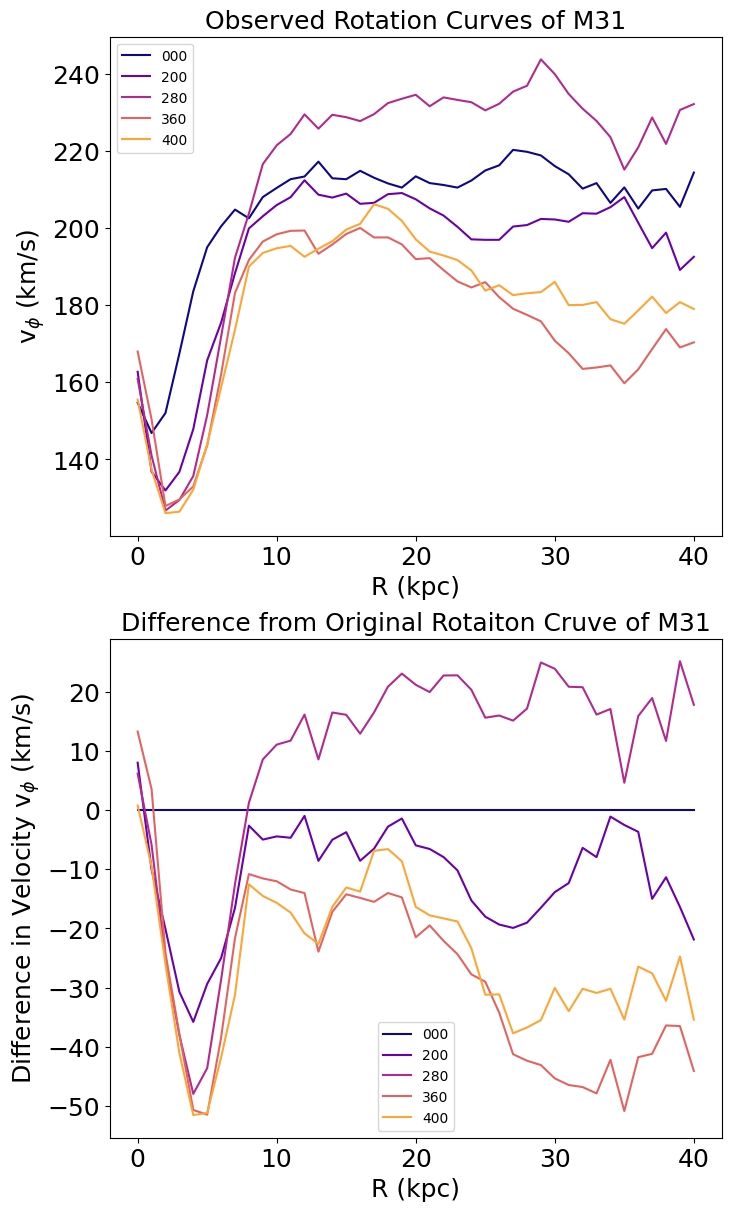

In [26]:
M31_Curves.plot_all_curves()

In [15]:
M31_Curves.snap_ids

array([  0, 200, 280, 360, 400])

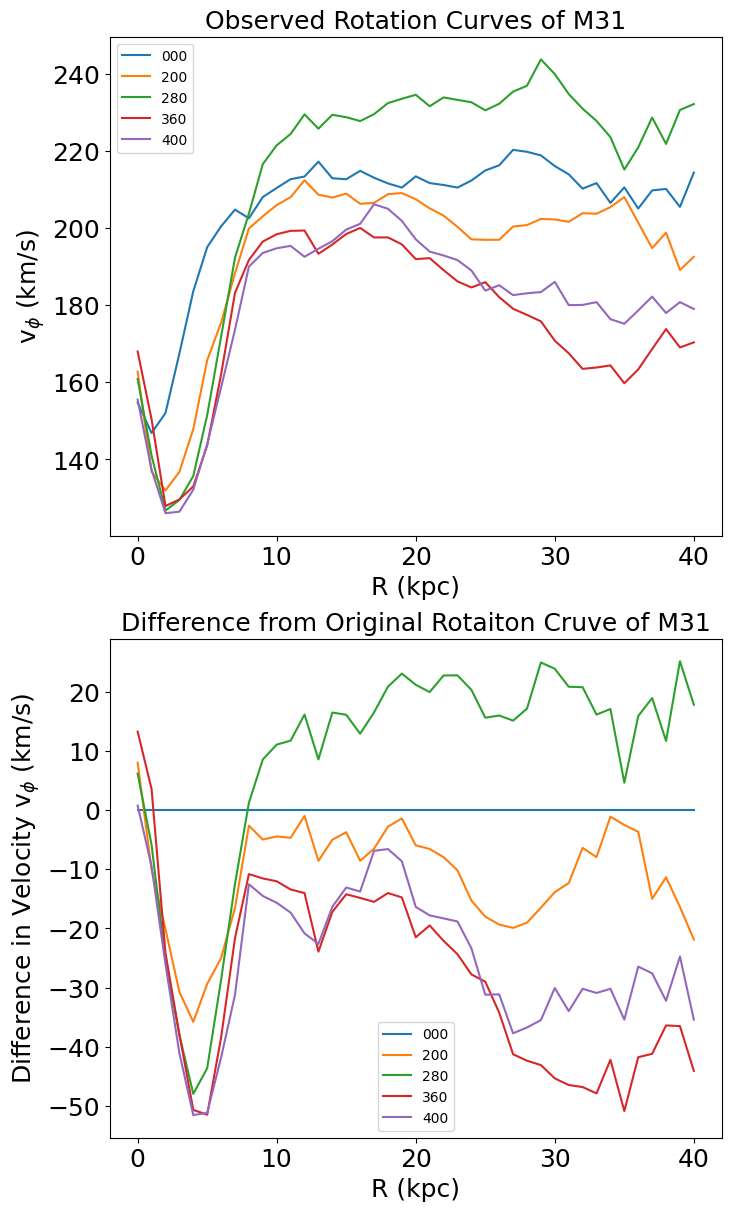

In [16]:
M31_Curves.plot_all_curves()

In [ ]:
for snap_id in M31_Curves.snap_ids:
    M31_Curves.plot(snap_id, save=True)
    M31_Curves.plot_residuals(snap_id, save=True)

In [ ]:
MW_Curves = Rotation_Curves("MW", snap_ids, r_end=20, dr=1)
MW_Curves.Calculate_Rotation_Curves()
MW_Curves.calc_residuals()

In [ ]:
MW_Curves.plot_all_curves()

In [ ]:
for snap_id in snap_ids:
    MW_Curves.plot(snap_id, xlim=50, save=True)
    MW_Curves.plot_residuals(snap_id, save=True)